In [87]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn import metrics
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

<h2>Função para Carregar e Pré-processar as Imagens</h2>
<ul>
    <li>A função <strong>load_images_and_labels</strong> é criada para automatizar o carregamento dos dados.</li>
    <li>Ela lê cada imagem a partir do diretório, converte para <strong>escala de cinza</strong> (<code>cv2.IMREAD_GRAYSCALE</code>)`.</li>
    <li>Os pixels são <strong>normalizados</strong> (divididos por 255.0) para que seus valores fiquem entre 0 e 1, o que melhora a estabilidade do treino da rede.</li>
    <li>Ao final, adiciona uma dimensão de canal, pois a CNN espera um formato de entrada (Altura, Largura, 1) para imagens em escala de cinza.</li>
</ul>

In [88]:
def load_images_and_labels(image_dir, df_metadata, target_size=(336, 448)):
    X = []
    y = []

    for idx, row in df_metadata.iterrows():
        file_name = row["file_name"]
        img_path = os.path.join(image_dir, file_name)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Erro ao carregar {img_path}")
            continue

        img_resized = cv2.resize(img, target_size[::-1])
        X.append(img_resized)
        y.append(row["class_id"])

    X = np.array(X)
    y = np.array(y)

    # Normalização
    X = X / 255.0
    # Adiciona canal (CNN espera H x W x 1)
    X = X[..., np.newaxis]

    return X, y

<h2>Preparação do Dataset</h2>
<ul>
    <li>Definimos o dicionário <strong>tabela_classes</strong> para mapear os nomes das frutas aos seus IDs.</li>
    <li>Carregamos os metadados do arquivo <code>dataset_full.csv</code> e usamos a função <code>load_images_and_labels</code> para carregar as imagens e seus respectivos rótulos.</li>
    <li><strong>One-Hot Encoding</strong>: A função <code>to_categorical</code> converte os rótulos numéricos (0, 1, 2...) em vetores binários (ex: 3 vira [0,0,0,1,0...]). Este formato é necessário para a função de perda <code>categorical_crossentropy</code>.</li>
    <li><strong>Divisão dos Dados</strong>: Usamos <code>train_test_split</code> duas vezes para dividir o dataset em três conjuntos: <strong>80% para treino</strong>, <strong>10% para validação</strong> e <strong>10% para teste</strong>, garantindo a estratificação para manter a proporção das classes em cada conjunto.</li>
</ul>

In [93]:
tabela_classes = {
    0: "acerola",
    1: "lemon",
    2: "cherry_tomato",
    3: "khaki",
    4: "banana",
    5: "lime",
    6: "clove_lemon",
    7: "avocado",
    8: "bergamot",
    9: "pear"
}

df_final = pd.read_csv("./docs/dataset_full.csv")
df_final["class_id"] = df_final["class_name"].map({v: k for k, v in tabela_classes.items()})

image_dir = "original_dataset"
X, y = load_images_and_labels(image_dir, df_final)

# One-hot encoding
y_cat = to_categorical(y)

# Divisão treino/validação/teste (80-10-10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42)

<h2>Construção e Compilação do Modelo CNN</h2>
<ul>
    <li>A função <strong>build_cnn</strong> define a arquitetura da nossa Rede Neural Convolucional.</li>
    <li><strong>Camadas Convolucionais (<code>Conv2D</code>)</strong>: Com ativação 'relu', são responsáveis por extrair características das imagens (bordas, texturas, etc.).</li>
    <li><strong>Camadas de Pooling (<code>MaxPooling2D</code>)</strong>: Reduzem a dimensão espacial dos mapas de características, diminuindo a carga computacional e ajudando a tornar o modelo mais robusto a variações de posição.</li>
    <li><strong>Camada <code>Flatten</code></strong>: Transforma os mapas de características 2D em um vetor 1D para alimentar as camadas densas.</li>
    <li><strong>Camadas Densas (<code>Dense</code>)</strong>: Camadas de neurônios totalmente conectados que realizam a classificação final.</li>
    <li><strong>Camada <code>Dropout</code></strong>: Técnica de regularização que desativa aleatoriamente 50% dos neurônios durante o treino para evitar overfitting.</li>
    <li><strong>Compilação (<code>model.compile</code>)</strong>: Prepara o modelo para o treino, definindo o otimizador (<code>adam</code>), a função de perda (<code>categorical_crossentropy</code>, ideal para classificação multiclasse) e a métrica de avaliação (<code>accuracy</code>).</li>
</ul>

In [90]:
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

<h2>Treinamento do Modelo</h2>
<ul>
    <li>Construímos o modelo chamando a função <code>build_cnn</code>.</li>
    <li>Iniciamos o treinamento com o método <strong><code>model.fit</code></strong>.</li>
    <li>Passamos os dados de <strong>treino</strong> (<code>X_train, y_train</code>) e os dados de <strong>validação</strong> (<code>X_val, y_val</code>), que são usados para monitorar o desempenho do modelo em dados não vistos a cada época.</li>
    <li>O treino é realizado por <strong>20 épocas</strong> (<code>epochs=20</code>), com um tamanho de lote de <strong>32</strong> (<code>batch_size=32</code>).</li>
</ul>

In [91]:
model = build_cnn(X.shape[1:], y_cat.shape[1])
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 91s 10s/step - accuracy: 0.0781 - loss: 4.5704 - val_accuracy: 0.1000 - val_loss: 2.3217
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 11s/step - accuracy: 0.0535 - loss: 2.3660 - val_accuracy: 0.1500 - val_loss: 2.2697
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 80s 10s/step - accuracy: 0.1769 - loss: 2.2675 - val_accuracy: 0.3000 - val_loss: 2.1818
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 102s 14s/step - accuracy: 0.3240 - loss: 2.0937 - val_accuracy: 0.3000 - val_loss: 1.9670
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 74s 14s/step - accuracy: 0.4254 - loss: 1.8261 - val_accuracy: 0.5000 - val_loss: 1.4876
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 64s 11s/step - accuracy: 0.4707 - loss: 1.4001 - val_accuracy: 0.6000 - val_loss: 1.0786
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 80s 11s/step - accuracy: 0.5655 - loss: 1.1048 - val_accuracy: 0.6500 - val_loss: 1.1456
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 79s 10s/step - accuracy: 0.7230 - loss: 0.8551 - val_accuracy: 0.6500 - val_loss: 0.8831

<h2>Avaliação de Desempenho e Visualização dos Resultados</h2>
<ul>
    <li>Usamos o modelo treinado para fazer previsões no conjunto de <strong>teste</strong>.</li>
    <li>Calculamos a <strong>Acurácia</strong> e o <strong>F1-Score</strong>, que são métricas gerais do desempenho do modelo.</li>
    <li><strong>Gráfico de Histórico</strong>: Plotamos a acurácia e a perda de treino e validação ao longo das épocas. Isso nos ajuda a identificar visualmente se o modelo está aprendendo bem ou se há overfitting (quando a performance no treino melhora, mas na validação piora).</li>
    <li><strong>Matriz de Confusão</strong>: Criamos um mapa de calor que mostra os acertos e erros do modelo para cada classe. A diagonal principal indica as previsões corretas.</li>
</ul>

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Accuracy: 0.7000
F1-Score: 0.7000


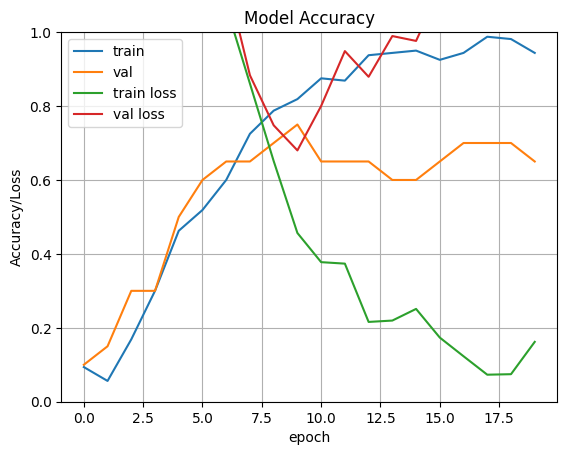

Confusion Matrix


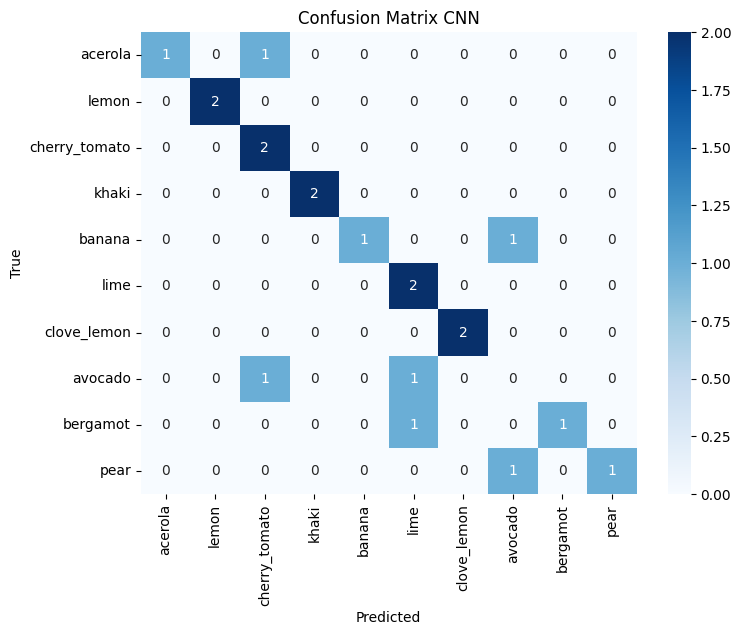

In [95]:
# Avaliar no teste
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_ = np.argmax(y_test, axis=1)

# Relatório

accuracy = accuracy_score(y_test_, y_pred)
print(f"Accuracy: {accuracy:.4f}")

f1 = f1_score(y_test_, y_pred, average='weighted')
print(f"F1-Score: {f1:.4f}")

plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy/Loss')
plt.xlabel('epoch')

plt.legend(['train', 'val', 'train loss', 'val loss'], loc='upper left')

plt.show()
print("Confusion Matrix")
# Matriz de confusão
class_names = list(tabela_classes.values())
cm = confusion_matrix(y_test_, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix CNN")
plt.show()

<h2>Análise da Curva ROC</h2>
<ul>
    <li>A <strong>Curva ROC (Receiver Operating Characteristic)</strong> é uma ferramenta importante para avaliar o desempenho de um classificador.</li>
    <li>Para um problema multiclasse, geramos uma curva ROC para cada classe usando a abordagem <strong>One-vs-Rest (OvR)</strong>.</li>
    <li>Calculamos a <strong>Área Sob a Curva (AUC)</strong> para cada classe. Um valor de AUC próximo de 1.0 indica um excelente poder de discriminação, enquanto um valor próximo de 0.5 sugere um desempenho similar a um classificador aleatório (linha tracejada).</li>
    <li>O gráfico nos permite visualizar quão bem o modelo consegue distinguir cada classe das demais.</li>
</ul>

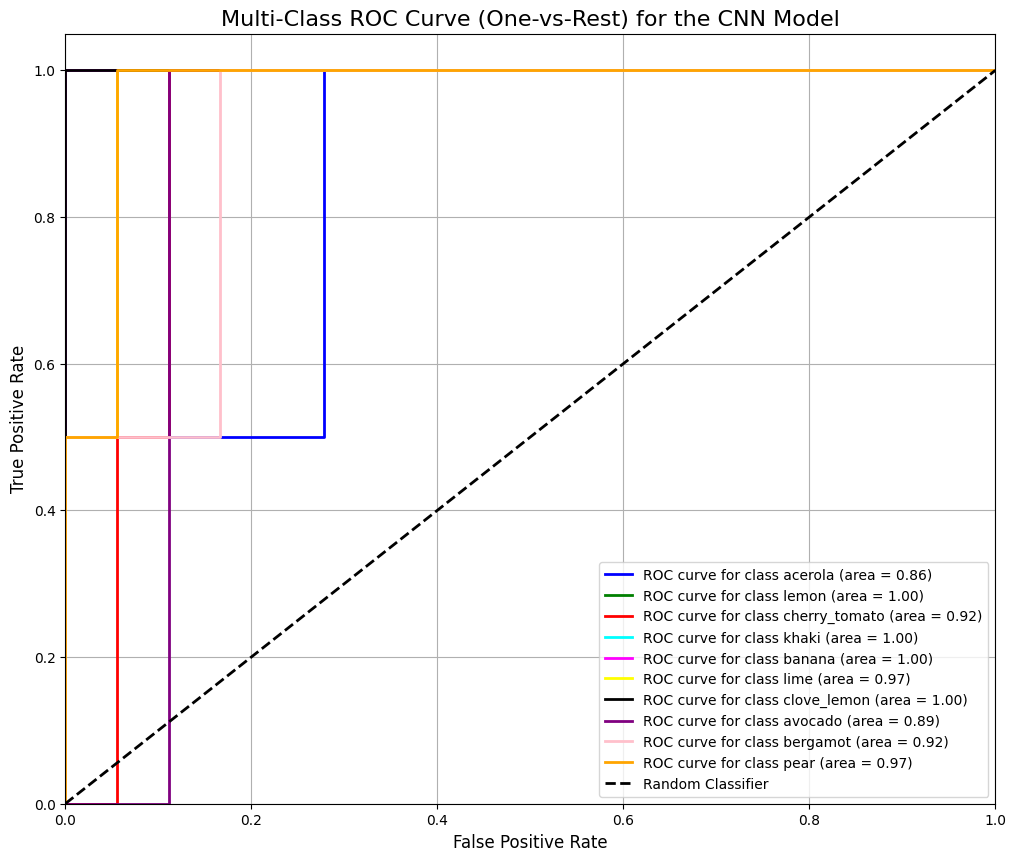

In [99]:
# Assuming these variables are already defined from previous cells:
# y_test_bin: The one-hot encoded true labels for the test set.
# y_pred_prob: The prediction probabilities from the model for the test set.
# class_names: A list of the string names for each class.
# num_classes: The total number of classes (e.g., 10).
num_classes = 10
y_test_bin = to_categorical(y_test_, num_classes=num_classes)

# Dictionaries to store the results for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# 2. Calculate the ROC curve and ROC area for each of the 10 classes
for i in range(num_classes):
    # Compares the 'i'th column of the true labels with the 'i'th column of the probabilities
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Plot all ROC curves on a single graph
plt.figure(figsize=(12, 10))

# Use a color cycle so that each curve has a different, legible color
colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'pink', 'orange'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {class_names[i]} (area = {roc_auc[i]:.2f})')

# Plot the reference line for a random classifier
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

# Final graph formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class ROC Curve (One-vs-Rest) for the CNN Model', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()